# Run the Keller-Segel program from Jupyter (Python)

Este cuaderno Jupyter se utiliza para ejecutar un programa (un *script*) en lenguaje [FreeFem++](www.freefem.org), con el fin de resolver numéricamente las ecuaciones de Keller-Segel:
$$
\begin{align}
u_t &= \Delta u - \nabla\cdot(u \nabla v),\\
v_t &= \Delta v - v + u,\\
\end{align}
$$
con condiciones de contorno
$$
\nabla u \cdot n = \nabla v \cdot n = 0 
$$
y post-procesar la salida, generando gráficas etc.

## 1. Crea un oggetto (che chiamiamo "freefem") per eseguire lo script

Prima, definiamo i parametri che lo script utilizzerà

In [11]:

%load_ext autoreload
%autoreload 2

# Load module to run programs
import pyrunner as pr

# Ruta a la carpeta donde está el script en lenguaje FreeFem++ (.edp)
# En este caso, se trata la carpeta actual, "." y de hecho este parámetro podría omitirse.
keller_segel_path = "." 
# Nombre del script
edp_file = "keller-segel.edp"
# Args passed to script
dt, nt = 1e-4, 80 # Time step and number of steps
edp_args = { "-dt": dt, "-nt": nt }
# Object specialized in running FreeFem++ scripts
keller_segel = pr.FreeFemRunner(
        edp_file, 
        args = edp_args
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2.- Esegui lo script e filtra l'output per ottenere i dati che ci interessano

L'esecuzione del programma tramite il modulo *pyrunner* ci consente di accedere a ciascuna riga dell'output della tua console. Attraverso di esso, accediamo ai dati prodotti dal programma. Questi dati vengono utilizzati per generare (in tempo reale) una tabella di risultati, attraverso il modulo *panda* e un grafico finale. Inoltre, l'evoluzione nel tempo viene indicata mediante una barra di avanzamento (utilizzando il modulo *ipywidgets*).

La ejecución del programa mediante el módulo *pyrunner* nos permite acceder a cada línea de su salida en consola. A través de ella, accedemos a los datos que produce el programa. Estos datos se utilizan para generar (en tiempo real) una tabla de resultados, mediante el módulo *pandas* y una gráfica final. Además, se muestra la evolución en tiempo mediante una barra de progreso (utilizando el módulo *ipywidgets*).

IntProgress(value=0, description='Time:', max=80)

,time,max(u),max(v)
1,0.0001,299.282,140.743
40,0.0040,549.722,139.004
80,0.0080,962.402,138.469


Running command:
FreeFem++ -cd  -nw  -ne  ./keller-segel.edp -nt 80 -dt 0.0001


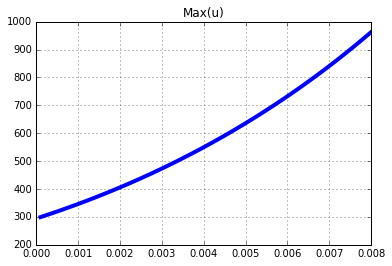

Raw data: max(u) = [299.282, 304.233, 309.253, 314.342, 319.502, 324.732, 330.034, 335.409, 340.856, 346.377, 351.973, 357.643, 363.389, 369.212, 375.111, 381.088, 387.144, 393.279, 399.493, 405.789, 412.165, 418.623, 425.164, 431.789, 438.497, 445.291, 452.169, 459.134, 466.186, 473.326, 480.555, 487.872, 495.28, 502.779, 510.369, 518.051, 525.827, 533.697, 541.662, 549.722, 557.879, 566.133, 574.486, 582.938, 591.489, 600.142, 608.897, 617.755, 626.716, 635.782, 644.955, 654.234, 663.62, 673.116, 682.722, 692.439, 702.269, 712.212, 722.269, 732.443, 742.734, 753.143, 763.671, 774.321, 785.093, 795.989, 807.01, 818.158, 829.434, 840.84, 852.377, 864.047, 875.852, 887.793, 899.872, 912.091, 924.451, 936.955, 949.605, 962.402] 

Raw data: max(v) = [140.743, 140.686, 140.63, 140.574, 140.519, 140.464, 140.41, 140.357, 140.304, 140.252, 140.201, 140.15, 140.1, 140.05, 140.001, 139.953, 139.906, 139.859, 139.812, 139.767, 139.722, 139.678, 139.634, 139.591, 139.549, 139.508, 139.467, 139.4

In [16]:
%%timeit -n 1 -r 1 # Ejecutar esta celda una sola vez vez, medir el tiempo y mostrarlo al final

# For graphics
import numpy as np
import matplotlib.pyplot as plt

# For tables
from pandas import DataFrame
from IPython.display import DisplayHandle

# For progress bar
import ipywidgets as widgets

# Show time in a progress bar widget
progress_bar = widgets.IntProgress(
    min=0,
    max=nt,
    description='Time:' )
display(progress_bar)

# Display data in a table
df = DataFrame(columns=["time", "max(u)","max(v)"])
handle = DisplayHandle()
handle.display(df)

# Run program and capture output (real time!)
output_lines = []
print_output = False
t=[]; u=[]; v=[]
i = 0
print_interval = 40

print("Running command:\n" + keller_segel.get_command())
for line in keller_segel.run():
    output_lines.append(line.data())
    if print_output: print(line)
    
    # Does this line contains time?
    time_found = line.find_float("t={}")
    if time_found:
        time = float(time_found)
        t.append(time)
        i = i+1
        progress_bar.value = i
        progress_bar.description = "{}/{} iter".format(i, nt)
        
    # Does this line contains max(u)?
    max_u_found = line.find_float("max\(u\): {}") 
    if max_u_found:
        max_u = float(max_u_found)
        u.append(max_u)
        
   # Does this line contains max(v)?
    max_v_found = line.find_float("max\(v\): {}")       
    if max_v_found:
        max_v = float(max_v_found)
        v.append(max_v)

        if i== 1 or i % print_interval == 0: # Show some lines in a table
            df.loc[i] = [time, max_u, max_v] 
            handle.update(df)

# Finished, plot result
plt.grid()
plt.plot(t, u, lw=4)    
plt.title("Max(u)")
plt.show()

# And also dump the data obtained
print("Raw data: max(u) =", u, "\n")
print("Raw data: max(v) =", v, "\n")
print("Computing time:")

In [13]:
keller_segel.print_output()

-- FreeFem++ v  3.380001 (date Sat Feb  6 20:00:25 UTC 2016)
 Load: lg_fem lg_mesh lg_mesh3 eigenvalue
 sizestack + 1024 =8000  ( 6976 )

Solving, iter: 1 (t=0.0001)
  max(u): 299.282
  max(v): 140.743
Solving, iter: 2 (t=0.0002)
  max(u): 304.233
  max(v): 140.686
Solving, iter: 3 (t=0.0003)
  max(u): 309.253
  max(v): 140.63
Solving, iter: 4 (t=0.0004)
  max(u): 314.342
  max(v): 140.574
Solving, iter: 5 (t=0.0005)
  max(u): 319.502
  max(v): 140.519
Solving, iter: 6 (t=0.0006)
  max(u): 324.732
  max(v): 140.464
Solving, iter: 7 (t=0.0007)
  max(u): 330.034
  max(v): 140.41
Solving, iter: 8 (t=0.0008)
  max(u): 335.409
  max(v): 140.357
Solving, iter: 9 (t=0.0009)
  max(u): 340.856
  max(v): 140.304
Solving, iter: 10 (t=0.001)
  max(u): 346.377
  max(v): 140.252
Solving, iter: 11 (t=0.0011)
  max(u): 351.973
  max(v): 140.201
Solving, iter: 12 (t=0.0012)
  max(u): 357.643
  max(v): 140.15
Solving, iter: 13 (t=0.0013)
  max(u): 363.389
  max(v): 140.1
Solving, iter: 14 (t=0.0014)
  m

In [14]:
keller_segel.print_code()

// Keller-Segel Italy-Spanish project

include "getARGV.idp";

verbosity = getARGV("-verb", 0);
int textVerbosity = 1;

// Mesh and finite element spaces
int nx = getARGV("-nx",40); // Number of mesh subdivisions
mesh Th = square(nx, nx, [4*x-2, 4*y-2]);

fespace Vh(Th,P1);
Vh u, u0, bu; // Solution at t_{n+1}, t_n, test function.
Vh v, v0, bv; // Solution at t_{n+1}, t_n, test function.

macro grad(u) [ dx(u), dy(u) ] // End of Macro
// Time parameters
real t = 0;
int nt = getARGV("-nt",10); // Number of time iterations
real dt = getARGV("-dt", 1.e-4); // Time step

// Keller-Segel data

real k1=0.2;
real k2=1;
real k3=0.1;
real k4=1;

real integral;

func initialU = 1.15*exp(-x^2-y^2)*(4-x^2)^2*(4-y^2)^2;
func initialU2 = 24*(((x^2-4)^2+(y^2-4)^2 + 1)-0.05*((x^2-4)^4+(y^2-4)^4));
func initialV = 0.55*exp(-x^2-y^2)*(4-x^2)^2*(4-y^2)^2;

u0 = initialU;
v0 = initialV;


// Variational problem

problem KellerSegelU(u,bu)=
int2d(Th) (
	u*bu/dt+grad(u)'*grad(bu))
- int2d(Th)(
	u0*bu/dt
	+ 